In [31]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/X-IIoTID dataset.csv


In [32]:
import pandas as pd 
df = pd.read_csv("/kaggle/input/X-IIoTID dataset.csv", low_memory=False)

random_state = 42

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 820834 entries, 0 to 820833
Data columns (total 68 columns):
 #   Column                       Non-Null Count   Dtype 
---  ------                       --------------   ----- 
 0   Date                         820503 non-null  object
 1   Timestamp                    820537 non-null  object
 2   Scr_IP                       820834 non-null  object
 3   Scr_port                     820834 non-null  object
 4   Des_IP                       820834 non-null  object
 5   Des_port                     820834 non-null  object
 6   Protocol                     820834 non-null  object
 7   Service                      820834 non-null  object
 8   Duration                     820834 non-null  object
 9   Scr_bytes                    820834 non-null  object
 10  Des_bytes                    820834 non-null  object
 11  Conn_state                   820834 non-null  int64 
 12  missed_bytes                 820834 non-null  object
 13  is_syn_only   

In [34]:
from sklearn.model_selection import train_test_split

"""Divide los datos en entrenamiento, validación y prueba."""
X = df.drop(columns=['class1', 'class2', 'class3'])
y_class3 = df['class3'].map({'Normal': 0, 'Attack': 1})
y_class2 = df['class2']
y_class1 = df['class1']

X_train, X_temp, y_train_class3, y_temp_class3, y_train_class2, y_temp_class2, y_train_class1, y_temp_class1 = train_test_split(
    X, y_class3, y_class2, y_class1, test_size=0.3, random_state=random_state, stratify=y_class3, shuffle=True
)

X_val, X_test, y_val_class3, y_test_class3, y_val_class2, y_test_class2, y_val_class1, y_test_class1 = train_test_split(
    X_temp, y_temp_class3, y_temp_class2, y_temp_class1, test_size=0.5, random_state=random_state, stratify=y_temp_class3, shuffle=True
)

# Resetear índices para evitar desalineaciones
X_train = X_train.reset_index(drop=True)
X_val = X_val.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)  # Opcional

y_train_class3 = y_train_class3.reset_index(drop=True)
y_val_class3 = y_val_class3.reset_index(drop=True)
y_test_class3 = y_test_class3.reset_index(drop=True)  # Opcional

y_train_class2 = y_train_class2.reset_index(drop=True)
y_val_class2 = y_val_class2.reset_index(drop=True)
y_test_class2 = y_test_class2.reset_index(drop=True)  # Opcional

y_train_class1 = y_train_class1.reset_index(drop=True)
y_val_class1 = y_val_class1.reset_index(drop=True)
y_test_class1 = y_test_class1.reset_index(drop=True)  # Opcional

In [35]:
import pandas as pd
def fix_dtype(df, umbral_numerico=0.7):
    object_cols = df.select_dtypes(include=['object']).columns
    int_cols = df.select_dtypes(include=['int64']).columns
    bool_cols = df.select_dtypes(include=['bool']).columns

    # Convertir booleanos a float
    df[bool_cols] = df[bool_cols].astype(float)

    for col in object_cols:
        valores_unicos = df[col].dropna().unique()

        if {"true", "false"} <= set(valores_unicos):  # Verifica si ambos existen
            df[col] = df[col].map({'true': 1, 'false': 0}).astype(float)
        else:
            converted = pd.to_numeric(df[col], errors='coerce')
            if converted.notna().mean() > umbral_numerico:
                df[col] = converted.astype(float)

    for col in int_cols:
        df[col] = df[col].astype(float)

    return df

def delete_ip_port(df):
    """Elimina las columnas 'ip' y 'port'."""
    lista = ['Scr_IP', 'Scr_port', 'Des_IP', 'Des_port', 'Scr_bytes', 'Des_bytes', 'Scr_pkts', 
                            'Des_pkts', 'Scr_ip_bytes', 'Des_ip_bytes', 'Scr_packts_ratio', 'Des_pkts_ratio',
                            'Scr_bytes_ratio', 'Des_bytes_ratio']

    return df.drop(columns=lista)

In [36]:
import numpy as np
# Reemplazos comunes de valores
common_replacements = {
    '-': np.nan,
    '?': np.nan,
    'nan': np.nan,
}

def replace_common_values(df):
    """Reemplaza valores comunes como '-', '?' y 'nan' por NaN."""
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].replace(common_replacements)
    return df

def fix_mayus(df):
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].str.lower()
    return df


In [37]:
from sklearn.impute import KNNImputer, SimpleImputer

# Definir los imputadores
imputers = {
    'categorical': {
        'most_frequent': SimpleImputer(strategy='most_frequent'),
        'knn': KNNImputer(n_neighbors=5)
    },
    'numeric': {
        'mean': SimpleImputer(strategy='mean'),
        'median': SimpleImputer(strategy='median')
    }
}

from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import RobustScaler

# Definir escaladores
scalers = {
    "robust": RobustScaler(),
    "standard": StandardScaler()
}

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

# Definir codificadores
encoders = {
    "one_hot": OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
    "ordinal": OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
}

In [38]:
imputador_cat= imputers['categorical']['most_frequent']
imputador_num = imputers['numeric']['mean']
normalizacion = scalers['robust']
decodificador = encoders['one_hot']

In [39]:
import numpy as np
from sklearn.decomposition import PCA
from collections import Counter

def matriz_correlacion(df):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    correlation_matrix = df[numeric_cols].corr()
    return correlation_matrix

def correlacion_pares(df, umbral):
    df = matriz_correlacion(df)
    # Toma solo la parte superior de la matriz para evitar duplicados
    upper_tri = df.where(np.triu(np.ones(df.shape), k=1).astype(bool))

    # Identifica pares altamente correlacionados
    correlated_pairs = []
    for col in upper_tri.columns:
        for row in upper_tri.index:
            if upper_tri.loc[row, col] > umbral:
                correlated_pairs.append((row, col))

    # Selecciona las columnas a eliminar (de cada par, se elimina la que aparece como columna)
    alta_corr_pares = [col for col in upper_tri.columns if any(upper_tri[col] > umbral)]
    
    return alta_corr_pares

def correlacion_respecto_objetivo(df, target, umbral):
    numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
    # Calculamos la correlación con la variable objetivo
    target_correlation = df[numeric_cols].corrwith(target).abs().sort_values(ascending=True)

    # Nos quedamos solo con las características que tengan correlación >= 0.1
    baja_corr_respecto_obj = target_correlation[target_correlation < umbral].index.tolist()

    return baja_corr_respecto_obj

def seleccionar_variables_pca(X_train, X_val, n_components, num_top_features):
    """
    Aplica PCA para seleccionar las características más influyentes, pero mantiene los datos originales.
    
    Parámetros:
        - X_train: DataFrame de entrenamiento
        - X_val: DataFrame de validación
        - n_components: float/int, cantidad de componentes principales o porcentaje de varianza a retener
        - num_top_features: int, número de características más influyentes a seleccionar

    Retorna:
        - X_train_filtrado: DataFrame de entrenamiento con las características seleccionadas
        - X_val_filtrado: DataFrame de validación con las características seleccionadas
    """

    # Si usas el sample, cambialo en las lineas necesarias
    # X_train_sample = X_train.sample(n=300000, random_state=42) # Seleccionar una muestra de 300,000 instancias como en el articulo
    
    # Aplicar PCA (sin guardar la transformación)
    pca = PCA(n_components=n_components, random_state=42)
    pca.fit(X_train)  # Solo ajustamos el modelo, no transformamos los datos

    # Obtener nombres originales de las variables
    original_feature_names = np.array(X_train.columns)

    # Contador de importancia de características en PCA
    feature_counter = Counter()
    
    for comp in pca.components_:
        top_indices = np.argsort(np.abs(comp))[-num_top_features:]  # Índices de las más importantes
        top_features = original_feature_names[top_indices]  # Obtener nombres
        feature_counter.update(top_features)  # Contar ocurrencias

    # Seleccionar las variables más influyentes ordenadas por frecuencia de aparición
    variables_pca = [feature for feature, _ in feature_counter.most_common()]

    # Filtrar las variables seleccionadas en los conjuntos de datos
    X_train_filtrado = X_train[variables_pca]
    X_val_filtrado = X_val[variables_pca]
    print("Características seleccionadas por PCA:", variables_pca)
    return X_train_filtrado, X_val_filtrado

In [40]:
def calculo_varianza(df):
    """Calcula las varianzas de las columnas de un DataFrame y devuelve las que tienen varianza igual a cero."""
    varianzas = df.var()

    # Identificar columnas con varianza igual a cero
    variables_con_varianza_cero = [col for col, varianza in varianzas.items() if varianza == 0]
    
    return variables_con_varianza_cero


In [41]:
X_train = replace_common_values(X_train)
X_train = fix_mayus(X_train)
X_train = fix_dtype(X_train)
X_train = delete_ip_port(X_train)

y_train_class3 = y_train_class3.loc[X_train.index]
y_train_class2 = y_train_class2.loc[X_train.index]
y_train_class1 = y_train_class1.loc[X_train.index]

X_val = replace_common_values(X_val)
X_val = fix_mayus(X_val)
X_val = fix_dtype(X_val)
X_val = delete_ip_port(X_val)

y_val_class3 = y_val_class3.loc[X_val.index]
y_val_class2 = y_val_class2.loc[X_val.index]
y_val_class1 = y_val_class1.loc[X_val.index]

In [42]:
X_train['Instancia_completa'] = X_train.notnull().all(axis=1).astype(int)
X_val['Instancia_completa'] = X_val.notnull().all(axis=1).astype(int)

completas = X_train['Instancia_completa'].sum()
incompletas = len(X_train) - completas
print(f"✅ Instancias completas: {completas}, incompletas: {incompletas}")
sample_weight_train = X_train['Instancia_completa'].replace({1: 3, 0: 1})

columnas_no_comprobar = [col for col in df.columns if col not in ['Timestamp', 'Date'] and df[col].dtypes != 'object']
variables_con_varianza_cero = calculo_varianza(X_train[columnas_no_comprobar])
X_train = X_train.drop(columns=variables_con_varianza_cero)
X_val = X_val.drop(columns=variables_con_varianza_cero)

X_train = X_train.drop(columns=['Timestamp', 'Date', 'Instancia_completa'], errors='ignore')
X_val = X_val.drop(columns=['Timestamp', 'Date', 'Instancia_completa'], errors='ignore')

alta_corr_pares = correlacion_pares(X_train, 0.97)
X_train = X_train.drop(columns=alta_corr_pares)
X_val = X_val.drop(columns=alta_corr_pares)

baja_corr_respecto_obj = correlacion_respecto_objetivo(X_train, y_train_class3, 0.025)
X_train = X_train.drop(columns=baja_corr_respecto_obj)
X_val = X_val.drop(columns=baja_corr_respecto_obj)

X_train['Protocol'] = X_train['Protocol'].fillna("missing")
X_val['Protocol'] = X_val['Protocol'].fillna("missing")

✅ Instancias completas: 416933, incompletas: 157650


/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


In [43]:
 # Identificar columnas categóricas, numéricas y booleanas
categorical_cols = X_train.select_dtypes(include=['object']).columns
boolean_cols = X_train.select_dtypes(include=['bool']).columns
if boolean_cols.any():  # Si hay columnas booleanas
    X_train[boolean_cols] = X_train[boolean_cols].astype(float)  # TAL VEZ INNCESESARIO
numerical_cols = X_train.select_dtypes(include=['float64', 'int64']).columns

##############################################################################
    
X_train[categorical_cols] = imputador_cat.fit_transform(X_train[categorical_cols])
X_val[categorical_cols] = imputador_cat.transform(X_val[categorical_cols])

X_train[numerical_cols] = imputador_num.fit_transform(X_train[numerical_cols])
X_val[numerical_cols] = imputador_num.transform(X_val[numerical_cols])

##############################################################################

X_train_scaled = normalizacion.fit_transform(X_train[numerical_cols])
X_val_scaled = normalizacion.transform(X_val[numerical_cols])

# Convertir las matrices escaladas a DataFrames
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=[f"{col}_scaled" for col in numerical_cols], index=X_train.index)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=[f"{col}_scaled" for col in numerical_cols], index=X_val.index)

##############################################################################

X_train_encoded = decodificador.fit_transform(X_train[categorical_cols])
X_val_encoded = decodificador.transform(X_val[categorical_cols])

# Obtener los nombres de las nuevas columnas codificadas
encoded_cols = decodificador.get_feature_names_out(categorical_cols)

# Convertir las matrices codificadas a DataFrames
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_cols, index=X_train.index)
X_val_encoded_df = pd.DataFrame(X_val_encoded, columns=encoded_cols, index=X_val.index)

##############################################################################

# Combinar con las características categóricas codificadas
X_train_processed = pd.concat([X_train_scaled_df, X_train_encoded_df], axis=1)
X_val_processed = pd.concat([X_val_scaled_df, X_val_encoded_df], axis=1)

# Opcional: Reordenar las columnas si es necesario
X_train = X_train_processed.reindex(sorted(X_train_processed.columns), axis=1)
X_val = X_val_processed.reindex(sorted(X_val_processed.columns), axis=1)

In [44]:
X_train, X_val = seleccionar_variables_pca(X_train_processed, X_val_processed, n_components=0.95, num_top_features=20)
caracteristicas = X_train.columns.tolist()

Características seleccionadas por PCA: ['is_syn_only_scaled', 'Avg_ideal_time_scaled', 'Avg_system_time_scaled', 'std_num_cswch/s_scaled', 'paket_rate_scaled', 'Avg_num_cswch/s_scaled', 'total_bytes_scaled', 'Protocol_tcp', 'Is_SYN_ACK_scaled', 'Std_user_time_scaled', 'Avg_nice_time_scaled', 'Std_system_time_scaled', 'read_write_physical.process_scaled', 'Avg_user_time_scaled', 'Avg_kbmemused_scaled', 'Duration_scaled', 'Protocol_udp', 'Service_coap', 'Service_dns', 'Avg_iowait_time_scaled', 'total_packet_scaled', 'Avg_tps_scaled', 'Service_http', 'Avg_ldavg_1_scaled', 'Std_nice_time_scaled', 'Service_websocket', 'OSSEC_alert_scaled', 'Avg_rtps_scaled', 'Service_mqtt', 'is_with_payload_scaled', 'anomaly_alert_scaled', 'File_activity_scaled', 'Login_attempt_scaled', 'Std_wtps_scaled']


In [45]:
print(X_train.shape, X_val.shape)
print(X_train.isnull().sum().sum(), X_val.isnull().sum().sum())
print(y_train_class3.value_counts(normalize=True))
print(y_val_class3.value_counts(normalize=True))

(574583, 34) (123125, 34)
0 0
class3
0    0.5134
1    0.4866
Name: proportion, dtype: float64
class3
0    0.513405
1    0.486595
Name: proportion, dtype: float64


In [46]:
from sklearn.preprocessing import LabelEncoder

# Para clase2:
label_encoder_class2 = LabelEncoder()
y_train_class2_encoded = label_encoder_class2.fit_transform(y_train_class2)
y_val_class2_encoded   = label_encoder_class2.transform(y_val_class2)
mapping_class2 = dict(enumerate(label_encoder_class2.classes_))

# Para clase1:
label_encoder_class1 = LabelEncoder()
y_train_class1_encoded = label_encoder_class1.fit_transform(y_train_class1)
y_val_class1_encoded   = label_encoder_class1.transform(y_val_class1)
mapping_class1 = dict(enumerate(label_encoder_class1.classes_))

print("Clase2 Encoded Train:", y_train_class2_encoded)
print("Clase2 Mapping:", mapping_class2)
print("Clase1 Encoded Train:", y_train_class1_encoded)
print("Clase1 Mapping:", mapping_class1)

Clase2 Encoded Train: [5 4 4 ... 4 4 4]
Clase2 Mapping: {0: 'C&C', 1: 'Exfiltration', 2: 'Exploitation', 3: 'Lateral _movement', 4: 'Normal', 5: 'RDOS', 6: 'Reconnaissance', 7: 'Tampering', 8: 'Weaponization', 9: 'crypto-ransomware'}
Clase1 Encoded Train: [12 11 11 ... 11 11 11]
Clase1 Mapping: {0: 'BruteForce', 1: 'C&C', 2: 'Dictionary', 3: 'Discovering_resources', 4: 'Exfiltration', 5: 'Fake_notification', 6: 'False_data_injection', 7: 'Generic_scanning', 8: 'MQTT_cloud_broker_subscription', 9: 'MitM', 10: 'Modbus_register_reading', 11: 'Normal', 12: 'RDOS', 13: 'Reverse_shell', 14: 'Scanning_vulnerability', 15: 'TCP Relay', 16: 'crypto-ransomware', 17: 'fuzzing', 18: 'insider_malcious'}


In [47]:
input_dim = X_train.shape[1]  # Número de características de entrada
num_classes_2 = len(set(y_train_class2_encoded))  # Cantidad de clases en y_class2
num_classes_1 = len(set(y_train_class1_encoded))  # Cantidad de clases en y_class1

In [48]:
timesteps = 1
# Convertir DataFrame a NumPy antes de redimensionar
X_train = np.array(X_train).reshape((X_train.shape[0], timesteps, X_train.shape[1]))
X_val = np.array(X_val).reshape((X_val.shape[0], timesteps, X_val.shape[1]))

In [49]:
from tensorflow import keras
from tensorflow.keras import layers

# Entrada
input_layer = keras.Input(shape=(timesteps, input_dim))  # Se necesita un input secuencial

# Capas ocultas con GRU
x = layers.GRU(200, return_sequences=True)(input_layer)
x = layers.GRU(200, return_sequences=True)(x)
x = layers.GRU(200)(x)  # Última capa sin return_sequences

# Salida binaria (puedes agregar más salidas si lo necesitas)
output_class3 = layers.Dense(1, activation='sigmoid', name="output_class3")(x)
output_class2 = layers.Dense(num_classes_2, activation='softmax', name="output_class2")(x)  # Multiclase
output_class1 = layers.Dense(num_classes_1, activation='softmax', name="output_class1")(x)  # Multiclase

# Definir el modelo con salida
model = keras.Model(inputs=input_layer, outputs=[output_class3, output_class2, output_class1])

# Compilar el modelo
model.compile(optimizer=keras.optimizers.RMSprop(),
              loss=['binary_crossentropy', 'sparse_categorical_crossentropy', 'sparse_categorical_crossentropy'],
              metrics=['accuracy', 'accuracy', 'accuracy'])


# Entrenar el modelo
history = model.fit(X_train,
                    [y_train_class3, y_train_class2_encoded, y_train_class1_encoded],
                    batch_size=250,
                    epochs=10,
                    validation_data=(X_val, [y_val_class3, y_val_class2_encoded, y_val_class1_encoded]))

Epoch 1/10
2299/2299 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 0.6324 - output_class1_accuracy: 0.9212 - output_class1_loss: 0.2869 - output_class2_accuracy: 0.9373 - output_class2_loss: 0.2202 - output_class3_accuracy: 0.9533 - output_class3_loss: 0.1254 - val_loss: 0.2001 - val_output_class1_accuracy: 0.9785 - val_output_class1_loss: 0.0747 - val_output_class2_accuracy: 0.9797 - val_output_class2_loss: 0.0682 - val_output_class3_accuracy: 0.9818 - val_output_class3_loss: 0.0570
Epoch 2/10
2299/2299 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - loss: 0.1650 - output_class1_accuracy: 0.9799 - output_class1_loss: 0.0616 - output_class2_accuracy: 0.9813 - output_class2_loss: 0.0560 - output_class3_accuracy: 0.9832 - output_class3_loss: 0.0473 - val_loss: 0.1383 - val_output_class1_accuracy: 0.9838 - val_output_class1_loss: 0.0484 - val_output_class2_accuracy: 0.9836 - val_output_class2_loss: 0.0477 - val_output_class3_accuracy: 0.9843 - val_output_class3_loss: 0.0421
Epoch 3/10
2299/2299 ━━━━━━━━━

In [50]:
# Predicción para salida de clase2
pred_class2 = model.predict(X_val)[1]
predicted_indices = np.argmax(pred_class2, axis=1)
predicted_names = label_encoder_class2.inverse_transform(predicted_indices)
print(predicted_names)

3848/3848 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
['Lateral _movement' 'Reconnaissance' 'Reconnaissance' ... 'Normal' 'RDOS'
 'RDOS']


In [51]:
# Predicción para salida de clase1
pred_class1 = model.predict(X_val)[1]
predicted_indices = np.argmax(pred_class1, axis=1)
predicted_names = label_encoder_class1.inverse_transform(predicted_indices)
print(predicted_names)

3848/3848 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step
['Discovering_resources' 'False_data_injection' 'False_data_injection' ...
 'Exfiltration' 'Fake_notification' 'Fake_notification']


In [52]:
X_test = replace_common_values(X_test)
X_test = fix_mayus(X_test)
X_test = fix_dtype(X_test)
X_test = delete_ip_port(X_test)

y_test_class3 = y_test_class3.loc[X_test.index]

X_test['Protocol'] = X_test['Protocol'].fillna("missing")

In [53]:
# Identificar columnas categóricas, numéricas y booleanas
categorical_cols = X_test.select_dtypes(include=['object']).columns
boolean_cols = X_test.select_dtypes(include=['bool']).columns
if boolean_cols.any():  # Si hay columnas booleanas
    X_test[boolean_cols] = X_test[boolean_cols].astype(float) # TAL VEZ INNCESESARIO
numerical_cols = X_test.select_dtypes(include=['float64', 'int64']).columns

##############################################################################

X_test[categorical_cols] = imputador_cat.fit_transform(X_test[categorical_cols])

X_test[numerical_cols] = imputador_num.fit_transform(X_test[numerical_cols])

##############################################################################

X_test_scaled = normalizacion.fit_transform(X_test[numerical_cols])

# Convertir las matrices escaladas a DataFrames
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=[f"{col}_scaled" for col in numerical_cols], index=X_test.index)

##############################################################################

X_test_encoded = decodificador.fit_transform(X_test[categorical_cols])

# Obtener los nombres de las nuevas columnas codificadas
encoded_cols = decodificador.get_feature_names_out(categorical_cols)

# Convertir las matrices codificadas a DataFrames
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_cols, index=X_test.index)

##############################################################################

# Combinar con las características categóricas codificadas
X_test_processed = pd.concat([X_test_scaled_df, X_test_encoded_df], axis=1)

# Opcional: Reordenar las columnas si es necesario
X_test_processed = X_test_processed.reindex(sorted(X_test_processed.columns), axis=1)

X_test = X_test_processed[caracteristicas]

In [54]:
# Convertir DataFrame a NumPy antes de redimensionar
X_test = np.array(X_test).reshape((X_test.shape[0], timesteps, X_test.shape[1]))

In [55]:
# Test:
y_test_class2_encoded = label_encoder_class2.transform(y_test_class2)
y_test_class1_encoded = label_encoder_class1.transform(y_test_class1)

print("Clase2 Encoded Test:", y_test_class2_encoded)
print("Clase1 Encoded Test:", y_test_class1_encoded)

Clase2 Encoded Test: [4 6 4 ... 8 6 5]
Clase1 Encoded Test: [11  7 11 ...  0 14 12]


3848/3848 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 0.0898 - output_class1_accuracy: 0.9888 - output_class1_loss: 0.0309 - output_class2_accuracy: 0.9890 - output_class2_loss: 0.0308 - output_class3_accuracy: 0.9894 - output_class3_loss: 0.0281
3848/3848 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Accuracy: 0.9887757301330566
Precision: 0.9932828282828283
Recall: 0.9847779279955936
F1-score: 0.9890120942395214


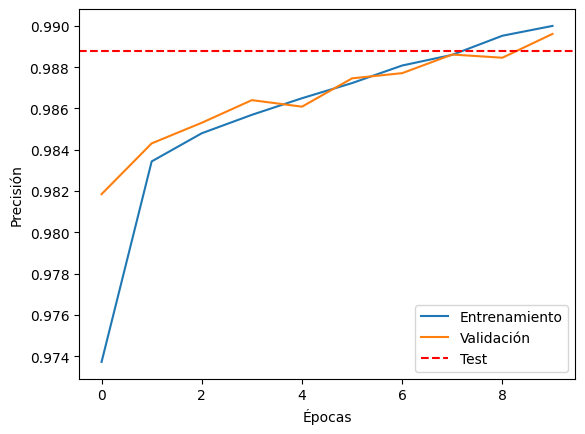

In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score

# Evaluar en test (se deben pasar las 3 salidas)
total_loss, loss_class3, loss_class2, loss_class1, test_acc3, test_acc2, test_acc1 = model.evaluate(
    X_test, [y_test_class3, y_test_class2_encoded, y_test_class1_encoded], verbose=1)

# Predecir y obtener la salida binaria (output_class3)
y_pred_probs = model.predict(X_test)[0]
y_pred = (y_pred_probs > 0.5).astype("int32")

precision = precision_score(y_test_class3, y_pred)
recall = recall_score(y_test_class3, y_pred)
f1 = f1_score(y_test_class3, y_pred)

print("Accuracy:", test_acc3)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

# Graficar la precisión de output_class3
plt.plot(history.history['output_class3_accuracy'], label='Entrenamiento')
plt.plot(history.history['val_output_class3_accuracy'], label='Validación')
plt.axhline(y=test_acc3, color='r', linestyle='--', label='Test')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()
plt.show()
